In [2]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='leaf-prisma')

Extracting data...


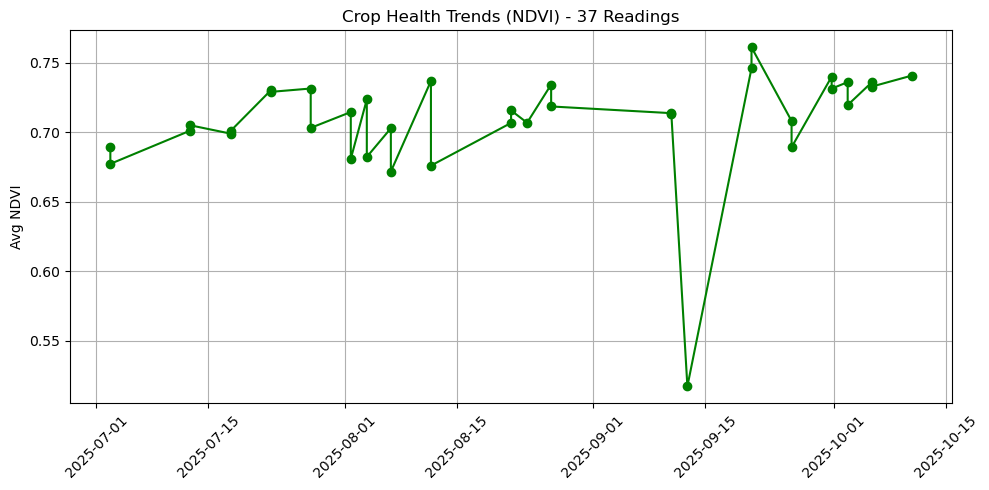

                      Date      NDVI
1  2025-07-02 18:16:22.497  0.689622
0  2025-07-02 18:16:26.469  0.677374
3  2025-07-12 18:16:23.706  0.701380
2  2025-07-12 18:16:27.676  0.705095
5  2025-07-17 18:16:03.674  0.699155
4  2025-07-17 18:16:07.647  0.701043
7  2025-07-22 18:16:23.388  0.730194
6  2025-07-22 18:16:27.359  0.729190
9  2025-07-27 18:16:01.662  0.731614
8  2025-07-27 18:16:05.642  0.703282
11 2025-08-01 18:16:21.255  0.714669
10 2025-08-01 18:16:25.230  0.680958
13 2025-08-03 18:16:17.108  0.723724
12 2025-08-03 18:16:21.084  0.682363
15 2025-08-06 18:16:01.844  0.702994
14 2025-08-06 18:16:05.821  0.671809
17 2025-08-11 18:16:19.421  0.737026
16 2025-08-11 18:16:23.401  0.676101
19 2025-08-21 18:16:20.034  0.706847
18 2025-08-21 18:16:24.010  0.715826
20 2025-08-23 18:16:14.776  0.706965
22 2025-08-26 18:16:02.135  0.734456
21 2025-08-26 18:16:06.108  0.718699
24 2025-09-10 18:16:14.866  0.713872
23 2025-09-10 18:16:18.847  0.713131
25 2025-09-12 18:16:16.951  0.517230
2

Map(center=[29.42359638593737, -110.91867413802873], controls=(WidgetControl(options=['position', 'transparent…

In [5]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

# 1. Define ROI
roi = ee.Geometry.Polygon([
    [
        [-110.921699, 29.423876],
        [-110.916021, 29.424890],
        [-110.915645, 29.423317],
        [-110.921334, 29.422303],
        [-110.921699, 29.423876]
    ]
])

# 2. Cloud Mask
def mask_s2_clouds(image):
    qa = image.select('QA60')
    mask = qa.bitwiseAnd(1<<10).eq(0).And(qa.bitwiseAnd(1<<11).eq(0))
    return image.updateMask(mask).divide(10000).copyProperties(image, ['system:time_start'])

# 3. Get Data
start_date = '2025-07-01'
end_date = '2025-10-15'

dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(start_date, end_date)
    .filterBounds(roi)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(mask_s2_clouds)
)

# 4. Calculate NDVI Mean (The Math)
def get_ndvi_mean(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    stats = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi,
        scale=10,
        maxPixels=1e9
    )
    # Important: We set the result on the image
    return image.set('NDVI_Mean', stats.get('NDVI'))

# Apply the math to create a NEW collection
time_series = dataset.map(get_ndvi_mean)

# 5. Extract Data (FIXED: Use 'time_series', not 'dataset')
print("Extracting data...")
data = time_series.reduceColumns(
    reducer=ee.Reducer.toList(2), 
    selectors=['system:time_start', 'NDVI_Mean']
).getInfo()['list']

# 6. Create DataFrame
df = pd.DataFrame(data, columns=['timestamp', 'NDVI'])
df = df.dropna()
df['Date'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.sort_values('Date')

# 7. Plot the Chart
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['NDVI'], marker='o', linestyle='-', color='green')
plt.title(f'Crop Health Trends (NDVI) - {len(df)} Readings')
plt.ylabel('Avg NDVI')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the numbers
print(df[['Date', 'NDVI']])

# 8. Render the Map (Restored)
m = geemap.Map(basemap="HYBRID")
m.centerObject(roi, 15)

# Visualizing just the LAST image in the series so you have something to look at
recent_image = dataset.sort('system:time_start', False).first()
ndvi_layer = recent_image.normalizedDifference(['B8', 'B4']).clip(roi)
ndviParams = {'min': 0, 'max': 0.8, 'palette': ['red', 'yellow', 'green']}

m.addLayer(roi, {'color': 'blue'}, 'Your Polygon')
m.addLayer(ndvi_layer, ndviParams, 'NDVI (Latest)')
m